In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix

from utils.dataset import IDC_Dataset, load_dataset, create_transforms
from utils.models import ConvNet

In [2]:
# Desactivem un warning de pytorch que podem ignorar (https://github.com/pytorch/pytorch/issues/97207)
import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                        message='TypedStorage is deprecated')


In [3]:
# Carreguem el dataset a partir del path on es troben les imatges
base_path = "./dataset/IDC_regular_ps50_idx5"
images, labels, metadata = load_dataset(base_path)

# Calcular mitjana i desviació estàndard per a normalitzar les imatges
mean = np.mean(images, axis=(0, 1, 2)) / 255
std = np.std(images, axis=(0, 1, 2)) / 255

data_transforms = create_transforms(mean, std)


Carregant imatges IDC-positives...: 100%|██████████| 78786/78786 [00:32<00:00, 2399.31it/s]


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 30
n_splits = 5
batch_size = 32
learning_rate = 0.0001
positive_threshold = 0.5

# Calculem el pes de les classes per a reduir l'esbiaixament del model
num_positives = np.sum(labels)
num_negatives = len(labels) - num_positives
pos_weight = num_negatives / num_positives
pos_weight = torch.tensor(pos_weight).to(device)

dataset = IDC_Dataset(images, labels, metadata, transform=data_transforms)
gkf = GroupKFold(n_splits=n_splits)

# Guardem la matriu de confusió per a cada iteració del model (epochs*n_splits en total)
confusion_matrices_train = []
confusion_matrices_val = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X=images, y=labels, groups=metadata[:, 0])):
    # El SubsetRandomSampler selecciona els items del dataset en els index dels splits
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=val_subsampler)

    # Instanciem el model per a cada fold
    model = ConvNet().to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # Entrenament del model
        model.train()
        all_outputs_train = []  # guardem les prediccions del conjunt d'entrenament
        all_labels_train = []  # guardem les etiquetes del conjunt d'entrenament
        for train_inputs, train_labels, _ in tqdm(train_loader, desc=f"TRAINING EPOCH {epoch+1}/{epochs}", unit=" batches"):
            train_inputs = train_inputs.to(device)
            train_labels = train_labels.to(device)

            optimizer.zero_grad()
            outputs = model(train_inputs)
            outputs = outputs.view(-1)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

            # Calculem la matriu de confusió per a cada batch
            predicted_outputs = outputs.sigmoid() > positive_threshold
            all_outputs_train.extend(predicted_outputs.cpu().numpy())
            all_labels_train.extend(train_labels.cpu().numpy())
        
        # Calculem la matriu de confusió d'entrenament per a cada epoch
        cm_train = confusion_matrix(all_labels_train, all_outputs_train)
        confusion_matrices_train.append(cm_train)

        # Validació del model
        model.eval()
        with torch.no_grad():
            all_outputs_val = [] # guardem les prediccions del conjunt de validació
            all_labels_val = [] # guardem les etiquetes del conjunt de validació
            for val_inputs, val_labels, _ in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                outputs = model(val_inputs)
                outputs = outputs.sigmoid() > positive_threshold
                all_outputs_val.extend(outputs.cpu().numpy())
                all_labels_val.extend(val_labels.cpu().numpy())

            # Calculem la matriu de confusió de validació per a cada epoch
            cm_val = confusion_matrix(all_labels_val, all_outputs_val)
            confusion_matrices_val.append(cm_val)


TRAINING EPOCH 30/30: 100%|██████████| 6881/6881 [00:57<00:00, 119.50 batches/s]


In [5]:
def compute_metrics(confusion_matrices, n_splits=n_splits, epochs=epochs):
    # Donat que tenim l'històric de les matrius de confusió per a cada iteració del model,
    # cal reordenar-les per a poder calcular la mitjana de les mètriques per a cada epoch
    # (fer la mitjana per a cada epoch dels folds)
    cm_array = np.array(confusion_matrices).reshape(n_splits, epochs, 2, 2)
    cm_array = cm_array.transpose(1, 0, 2, 3)

    # Mètriques que calcularem
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch_cm in cm_array:
        epoch_accuracies = []
        epoch_precisions = []
        epoch_recalls = []
        epoch_f1_scores = []

        # Calcular les mètriques per a cada epoch
        for cm in epoch_cm:
            tn, fp, fn, tp = cm.ravel()

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision +
                                             recall) if (precision + recall) > 0 else 0

            epoch_accuracies.append(accuracy)
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1_scores.append(f1)

        # Calcular la mitjana de les mètriques per a cada epoch
        accuracies.append(np.mean(epoch_accuracies))
        precisions.append(np.mean(epoch_precisions))
        recalls.append(np.mean(epoch_recalls))
        f1_scores.append(np.mean(epoch_f1_scores))

    accuracies = np.array(accuracies)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)

    return accuracies, precisions, recalls, f1_scores


def plot_metrics(accuracies, precisions, recalls, f1_scores, title=None):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), squeeze=False, sharex=False, sharey=False)
    fig.suptitle(title)

    axs[0, 0].plot(accuracies)
    axs[0, 0].set_title('Accuracy')

    axs[0, 1].plot(precisions, 'tab:orange')
    axs[0, 1].set_title('Precision')

    axs[1, 0].plot(recalls, 'tab:green')
    axs[1, 0].set_title('Recall')

    axs[1, 1].plot(f1_scores, 'tab:red')
    axs[1, 1].set_title('F1 Score')

    plt.show()


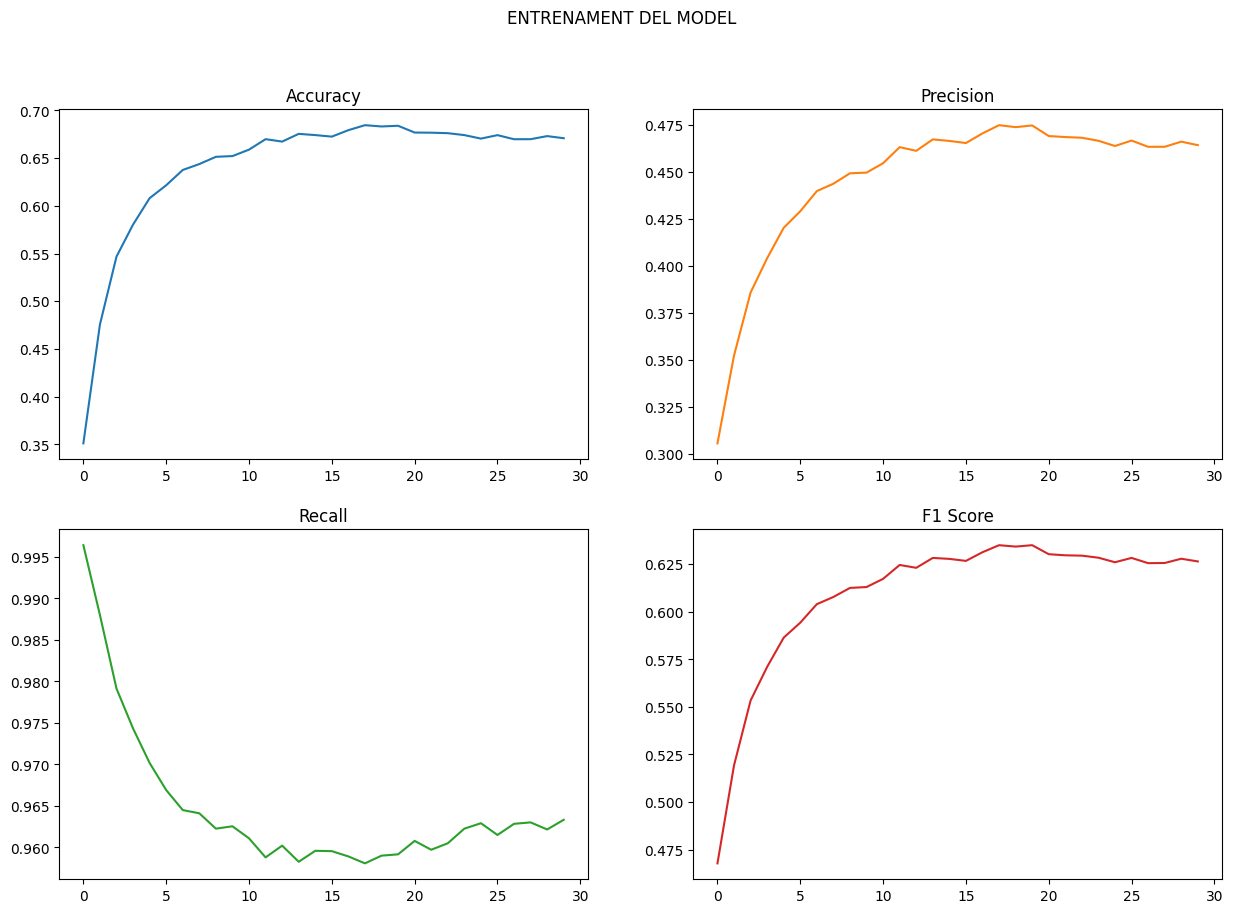

In [7]:
train_metrics = compute_metrics(confusion_matrices_train)
plot_metrics(*train_metrics, title="ENTRENAMENT DEL MODEL")

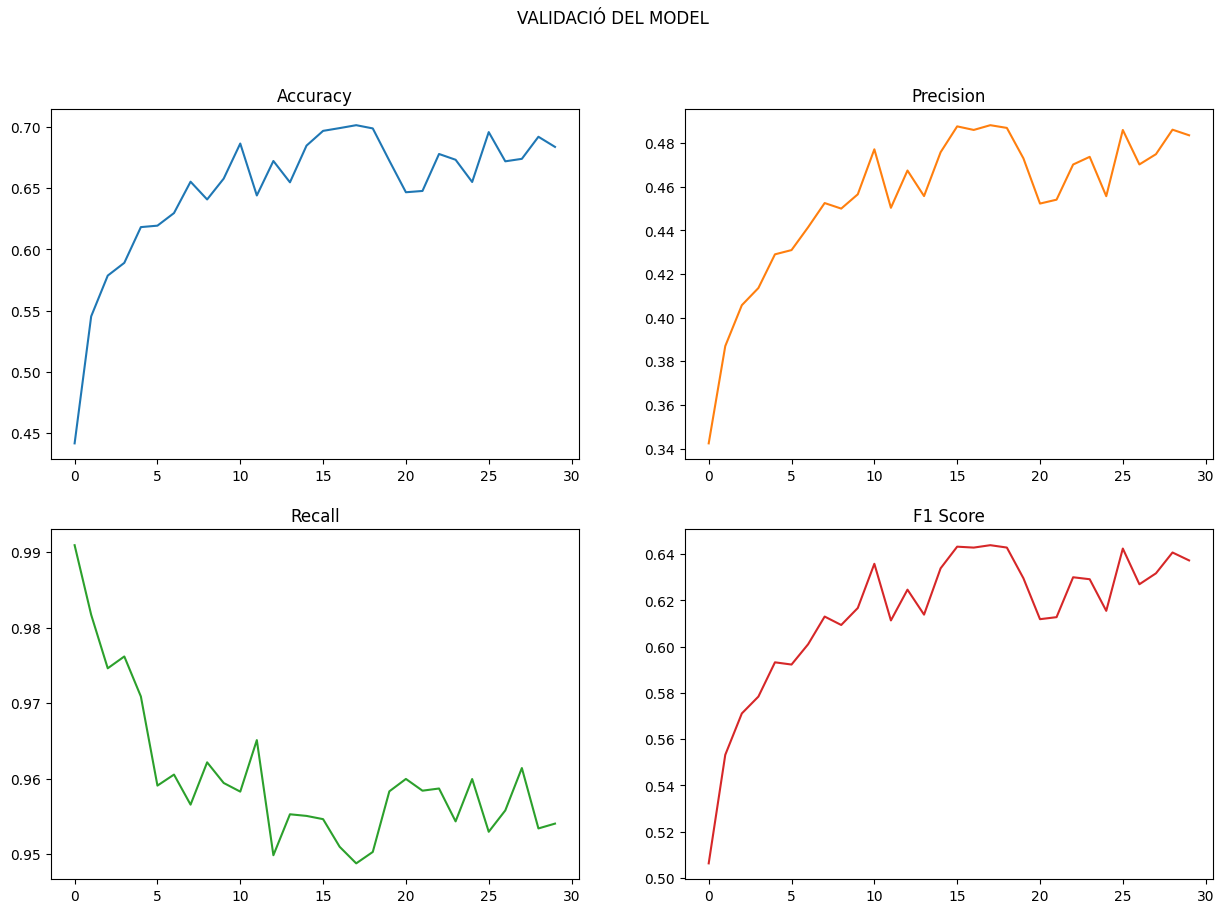

In [8]:
val_metrics = compute_metrics(confusion_matrices_val)
plot_metrics(*val_metrics, title="VALIDACIÓ DEL MODEL")